### Initialization

In [1]:
from pathlib import Path
import open3d as o3d
import os

from pytorch_lightning import seed_everything

from src.dataset_utils import (
    get_singleview_data,
    get_multiview_data,
    get_voxel_data_json,
    get_image_transform_latent_model,
    get_pointcloud_data,
    get_mv_dm_data,
    get_sv_dm_data,
    get_sketch_data
)
from src.model_utils import Model
from src.mvdream_utils import load_mvdream_model
import argparse
from PIL import Image


from comet_ml import start
from comet_ml.integration.pytorch import log_model
from comet_ml.api import API

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

import time

import Optim_Utils
from Optim_Utils import Optim_Visualizations

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [ ]:

def simplify_mesh(obj_path, target_num_faces=1000):
    mesh = o3d.io.read_triangle_mesh(obj_path)
    simplified_mesh = mesh.simplify_quadric_decimation(target_num_faces)
    o3d.io.write_triangle_mesh(obj_path, simplified_mesh)


def generate_3d_object(
    model,
    data,
    data_idx,
    scale,
    diffusion_rescale_timestep,
    image_name,
    experiment,
    save_dir="examples",
    output_format="obj",
    target_num_faces=25000,
    seed=42,
    
):
    # Set seed
    seed_everything(seed, workers=True)

    save_dir.mkdir(parents=True, exist_ok=True)
    model.set_inference_fusion_params(scale, diffusion_rescale_timestep)
    output_path = model.test_inference(
        data, data_idx, experiment, image_name = image_name, save_dir=save_dir, output_format=output_format
    )
    time_simplify = time.time()
    if output_format == "obj" and target_num_faces:
        simplify_mesh(output_path, target_num_faces=target_num_faces)
    time_diff = time.time() - time_simplify
    print('Simplication Time', time_diff, 's')
    try:
        experiment.log_metric("Simplification Time", time_diff)
    except:
        pass

In [ ]:
model_name = 'ADSKAILab/WaLa-SV-1B'
images_path = Path('examples/single_view/')
single_image = ['examples/single_view/table.png']

output_dir = 'examples/Test_Gen'
output_format = 'obj'
target_num_faces = 25000
scale = 1.8
seed = 42
diffusion_rescale_timestep = 5

print(f"Loading model")


model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()
model.set_inference_fusion_params(
        scale, diffusion_rescale_timestep
    )
experiment = None

### Test 1 - 3 images

In [ ]:
def run_inference(image_path,save_dir,model,experiment= None):
    for idx, image_path in enumerate(image_path.iterdir()):  # Enumerate to get the index
        timer1 = time.time()
        print(f"Processing image: {image_path}")
        data = get_singleview_data(
            image_file=Path(image_path),
            image_transform=image_transform,
            device=model.device,
            image_over_white=False,
        )
        data_idx = 0
        save_dir = Path(output_dir) 
        base_name = os.path.basename(image_path)
        image_name = os.path.splitext(base_name)[0]  
        model.set_inference_fusion_params(
            scale, diffusion_rescale_timestep
        )

        generate_3d_object(
            model,
            data,
            data_idx,
            scale,
            diffusion_rescale_timestep,
            image_name,
            experiment,
            save_dir,
            output_format,
            target_num_faces,
            seed,
        )
        delta = time.time() - timer1
        print('Total Inference time', delta)
        try:
            delta = time.time() - timer1
            experiment.log_metric("Default Delta", delta)
            print('Total Inference time', delta)
        except:
            pass
run_inference(images_path,output_dir,model)


## Dataset Extraction and Utilization for Benchmarking

#### Utils

In [ ]:
source_folder = os.path.expanduser('~/Obj_generated')
destination_folder = Path("/home/ray/WaLa/Benchmark_quality/Original")
check_folder = Path("/home/ray/WaLa/Benchmark_quality/Simplified")

Optim_Utils.find_and_move_matching_files(source_folder, check_folder, destination_folder)


In [ ]:
source_folder = os.path.expanduser('~/Obj_generated')
check_folder = Path("/home/ray/WaLa/Benchmark_quality/Original")
destination_folder = Path("/home/ray/WaLa/Benchmark_quality/Simplified")

# Check the contents of each folder
Optim_Utils.check_folder_contents(source_folder)
Optim_Utils.check_folder_contents(check_folder)
Optim_Utils.check_folder_contents(destination_folder)

### Dataset download and extraction

In [ ]:
zip_dir = '/home/ray/WaLa/Raw_data'         # Folder with zip files
output_dir = '/home/ray/WaLa/test_images'  # Where to save extracted thumbnails
os.makedirs(output_dir, exist_ok=True)

Optim_Utils.extract_first_thumbnail('/home/ray/WaLa/Raw_data', '/home/ray/WaLa/test_images')

In [ ]:
folder1 = "/home/ray/WaLa/Benchmark_quality/Original"
folder2 = "/home/ray/WaLa/Benchmark_quality/Simplified"
Optim_Utils.compare_file_sizes(folder1, folder2)

### Dataset Inference Tests

In [ ]:
experiment = start(
  api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ",
  project_name="wala-time-checks",
  workspace="alessandro-giuliano")


  # Define the hyperparameters
hyperparameters = {
    "model_name": "ADSKAILab/WaLa-SV-1B",
    "images_path": str(Path("examples/single_view/")),
    "single_image": ["examples/single_view/table.png"],
    "output_dir": "examples/Test_Gen",
    "output_format": "obj",
    "target_num_faces": None,
    "scale": 1.8,
    "seed": 42,
    "diffusion_rescale_timestep": 5,
    "Mcubes-Optimized": True,
    "Object-3D_simplified_mesh": 'Quadratic (Post)',
}

# Log the hyperparameters to Comet
experiment.log_parameters(hyperparameters)

In [ ]:
### Scanned Objects by Google Research
google_test_img_path = Path(os.path.expanduser('~/test_images'))  # Expands '~' to the full home directory path
output_dir = os.path.expanduser('~/Obj_generated')

model = Model.from_pretrained(pretrained_model_name_or_path=model_name)
image_transform = get_image_transform_latent_model()

run_inference(google_test_img_path,output_dir,model, experiment)

experiment.end()

### Data Visualization

COMET WARNING: Failed to check backend version at URL: 'https://comet.dev.cloudos.autodesk.com/clientlib/isAlive/ver'


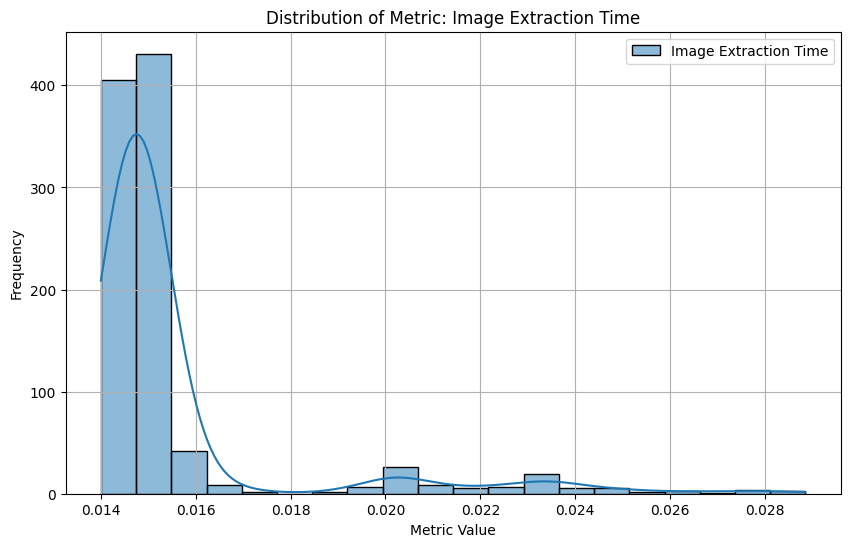

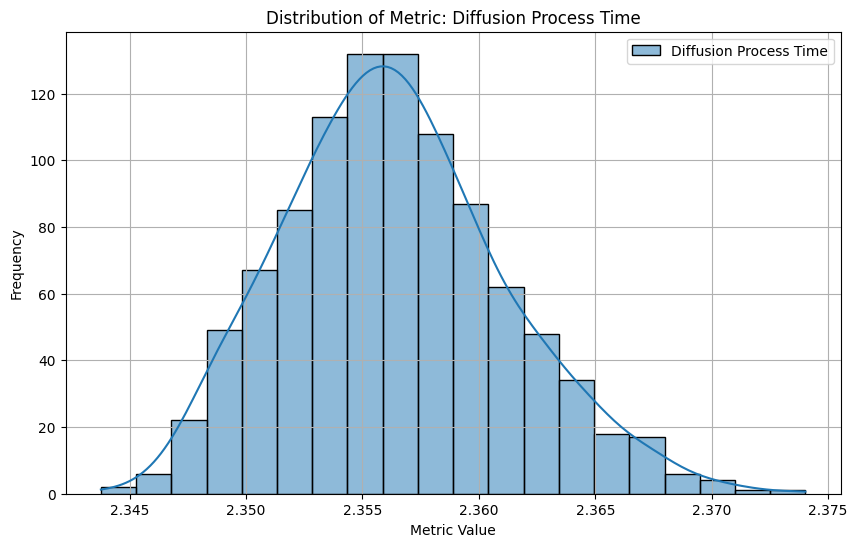

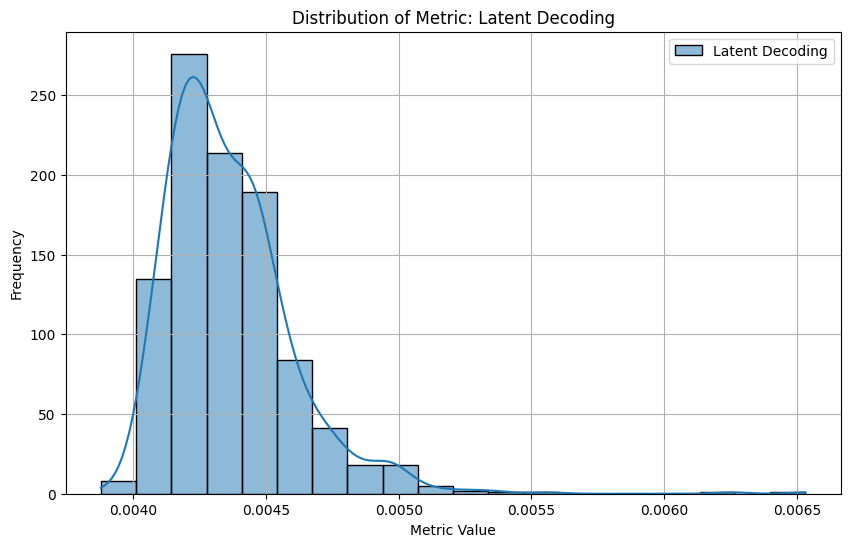

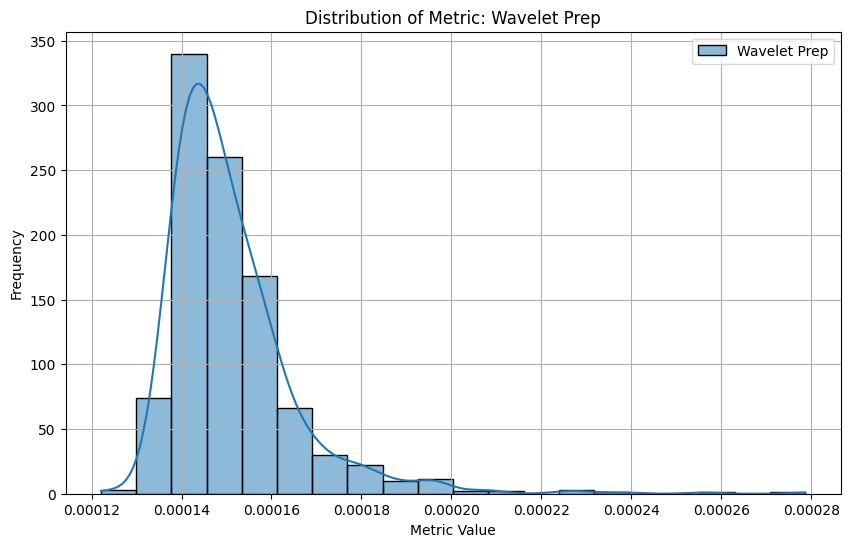

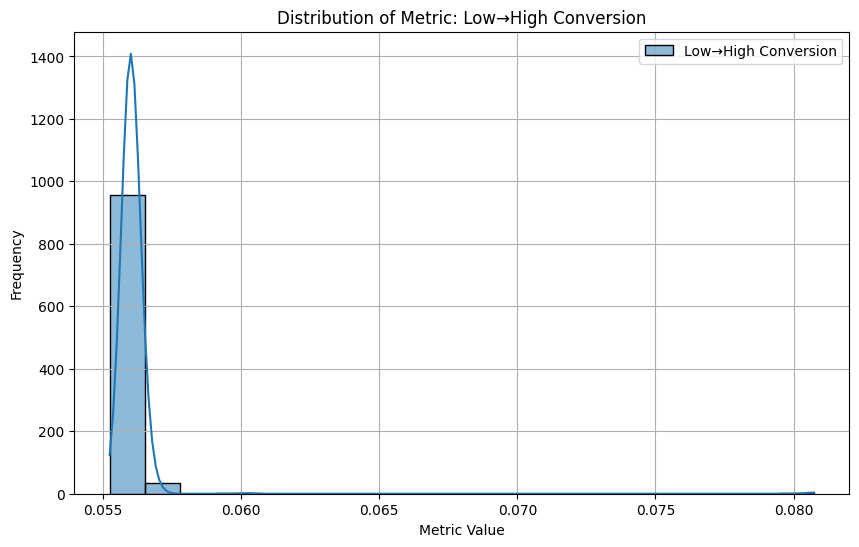

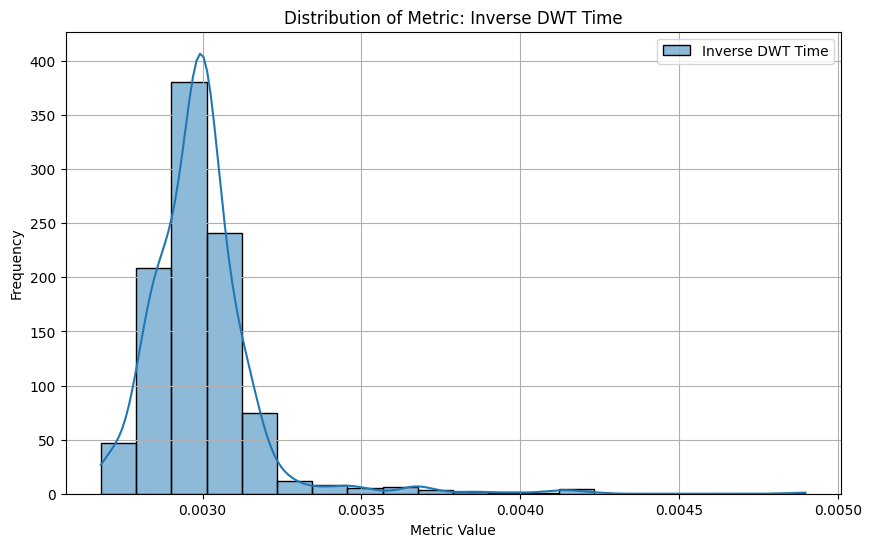

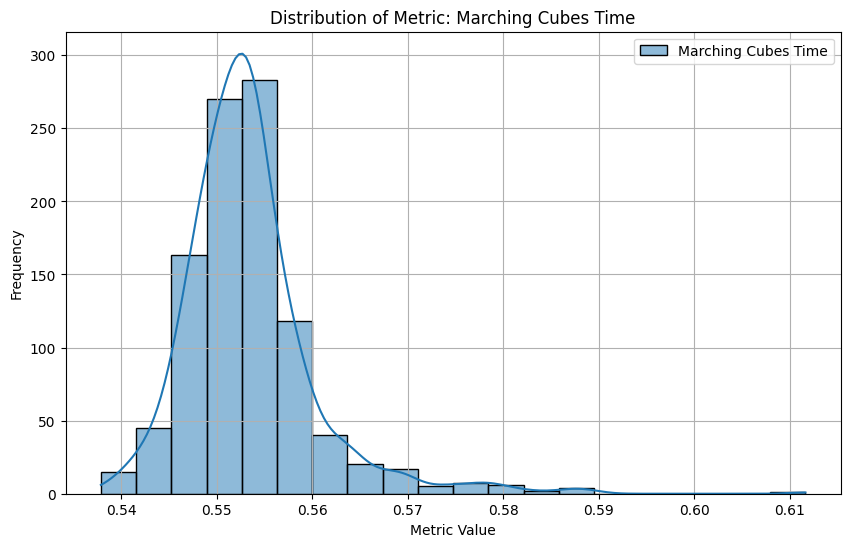

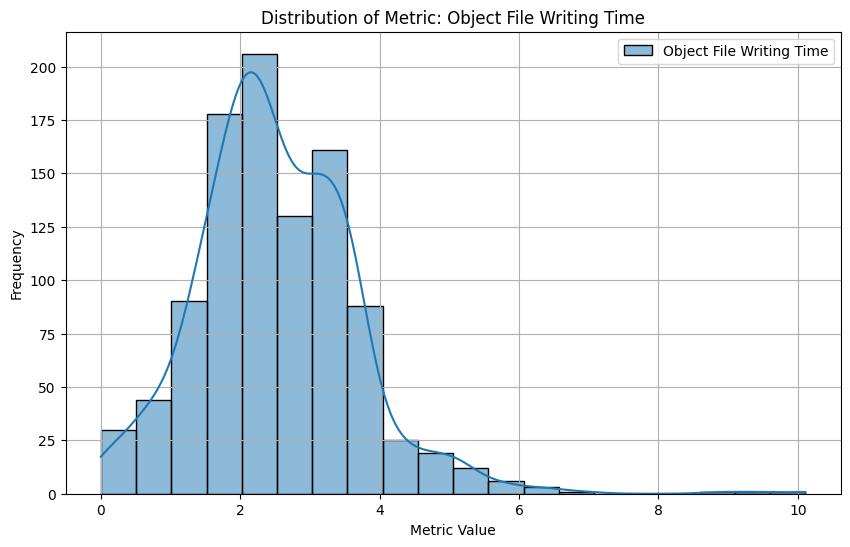

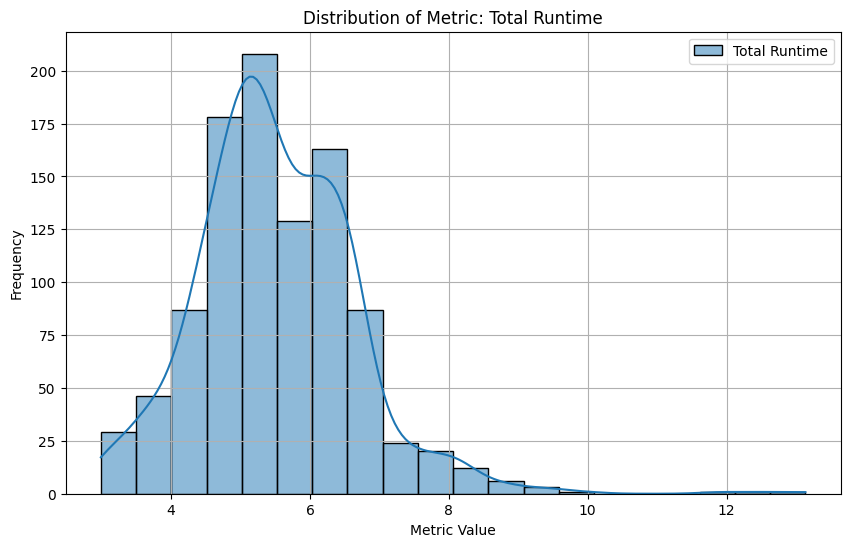

In [2]:
api_key="mqrUAXjKBRul24uX6pxR3gRHX*eyJiYXNlVXJsIjoiaHR0cHM6Ly9jb21ldC5kZXYuY2xvdWRvcy5hdXRvZGVzay5jb20ifQ"
comet_api = API(api_key=api_key)
project_name="wala-time-checks"
workspace="alessandro-giuliano"
experiment_key = '1bf42d8c3ee545628968903512893acf'
experiment_keys = {'Benchmark' : '1bf42d8c3ee545628968903512893acf',
                    'mcubes_fast_write' : '223ac82d90fc4292a33c60cc93e9f929',
                    'Simplified Vertex' : '7fa0d3b99b0d48588f11da362ed52aca',
                    'Simplified Quadratic (Inside)' : '86c28056aca843ef9f450d948beb7c61',
                    'Simplified Quadratic (Outside)' : 'ab20f6ca2c98422399ebae16ad717dff'}
                    
                    
# Retrieve the experiment
experiment = comet_api.get_experiment(workspace, project_name, experiment_keys['Benchmark'])



all_metric_data, metric_names, metric_display_names = Optim_Visualizations.retrieve_and_plot(experiment,plotting = True)


In [3]:

metric_statistics, default_delta_values = Optim_Visualizations.get_stats(experiment, metric_names, display = True)


Metric Statistics:

Extract Image:
  Mean: 0.0156
  Median: 0.0148
  Min: 0.0140
  Max: 0.0289
  Sum: 15.4203

Latent Diffusion Time:
  Mean: 2.3564
  Median: 2.3561
  Min: 2.3438
  Max: 2.3740
  Sum: 2342.2222

Latent Decoding Time:
  Mean: 0.0044
  Median: 0.0043
  Min: 0.0039
  Max: 0.0065
  Sum: 4.3371

Wavelet Preparation Time:
  Mean: 0.0002
  Median: 0.0001
  Min: 0.0001
  Max: 0.0003
  Sum: 0.1500

Low to Highs conversion:
  Mean: 0.0561
  Median: 0.0560
  Min: 0.0552
  Max: 0.0807
  Sum: 55.7399

Inverse DWT time elapsed:
  Mean: 0.0030
  Median: 0.0030
  Min: 0.0027
  Max: 0.0049
  Sum: 2.9833

mcubes.marching_cubes time:
  Mean: 0.5534
  Median: 0.5527
  Min: 0.5379
  Max: 0.6116
  Sum: 551.1406

export obj time:
  Mean: 2.5208
  Median: 2.3933
  Min: 0.0027
  Max: 10.1085
  Sum: 2510.6694

Total Sum of All Metrics (excluding Default Delta): 5482.6627
Default Delta Sum: 5498.1748

The total sum of all metrics is 99.72% of the Default Delta.


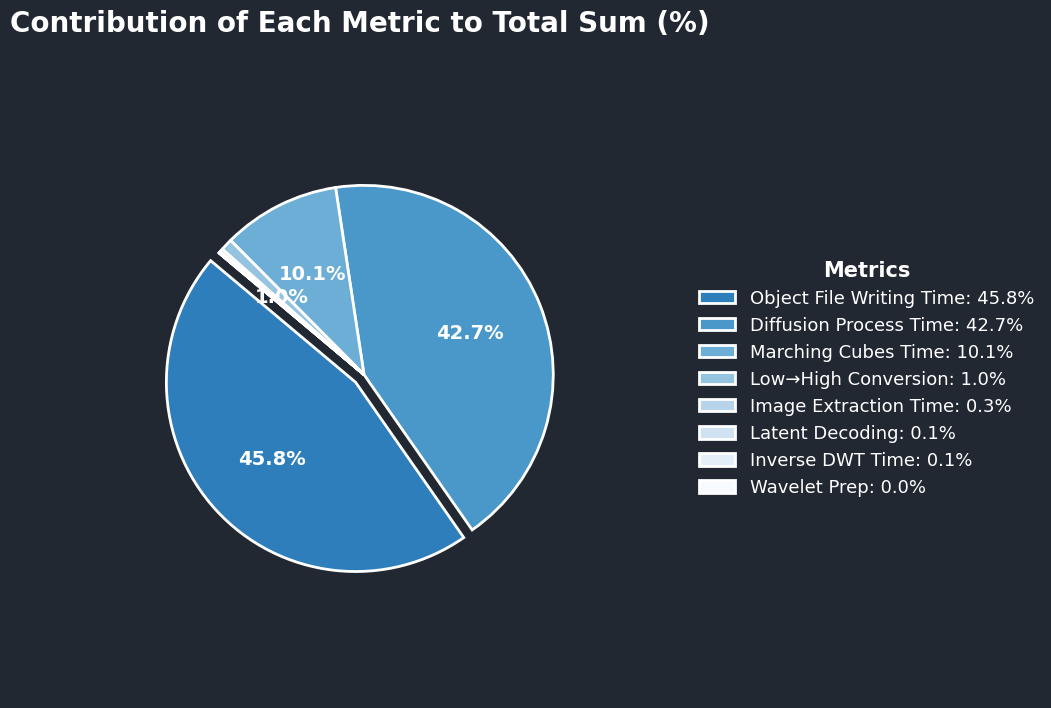

In [4]:
Optim_Visualizations.plot_metric_pie(metric_statistics,metric_display_names)

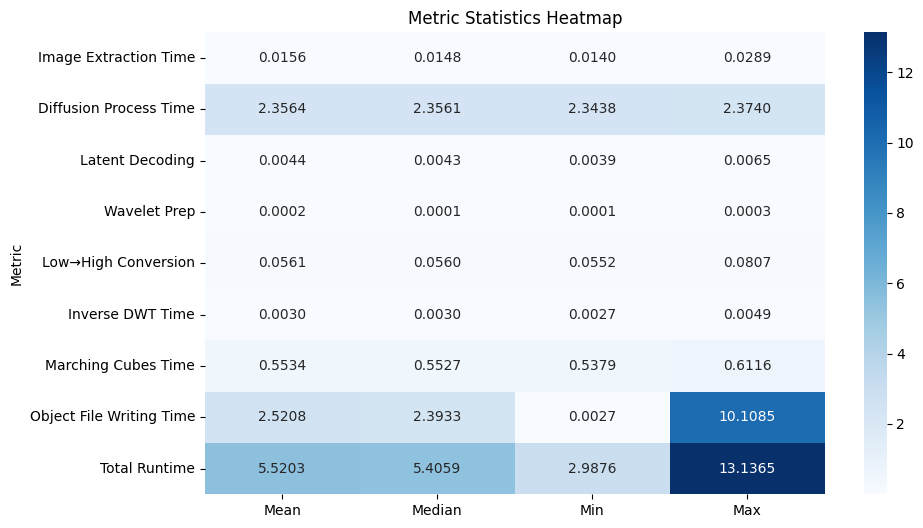

In [ ]:
Optim_Visualizations.plot_metric_heatmap(
    metric_statistics,
    metric_display_names,
    default_delta_values,
    include_min=True,
    include_max=True,
    include_median=True
)

#### Display Comparisons

WaLa Original: mean = 2.5208, std = 1.1495
WaLa MCubes Fast Write: mean = 1.2203, std = 0.5583


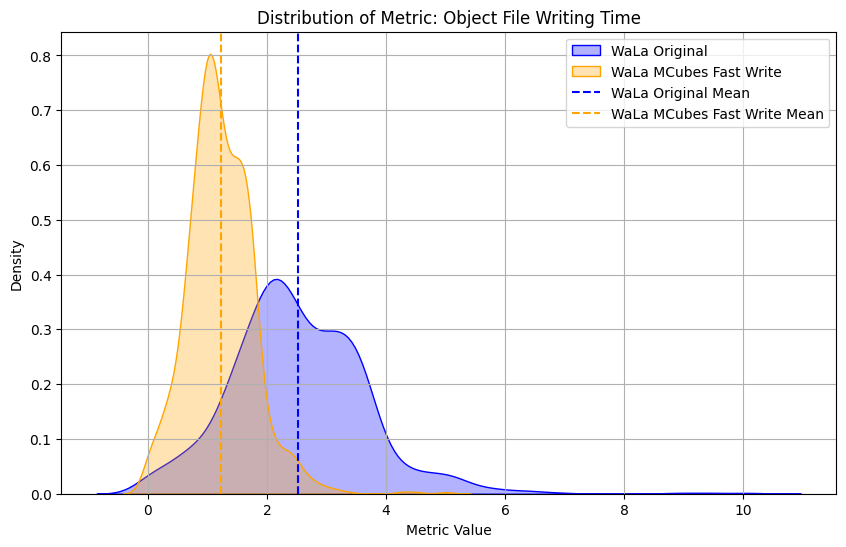

Percentage change in mean: -51.59%
WaLa Original: mean = 5.5203, std = 1.1545
WaLa MCubes Fast Write: mean = 4.2203, std = 0.5620


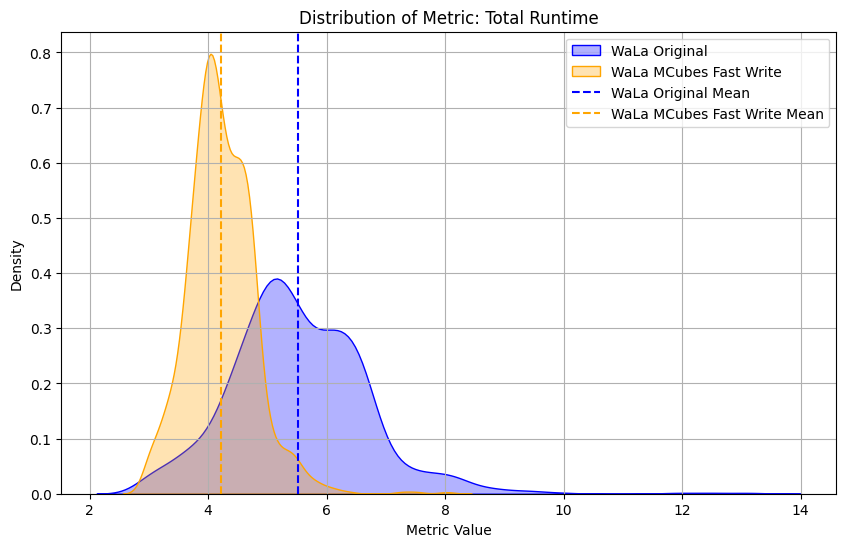

Percentage change in mean: -23.55%


In [6]:

# Retrieve both experiments
experiment1 = comet_api.get_experiment(workspace, project_name, experiment_keys['Benchmark'])
experiment2 = comet_api.get_experiment(workspace, project_name, experiment_keys['mcubes_fast_write'])


# Compare "export obj time"
Optim_Visualizations.compare_metric_distribution(
    experiment1, experiment2, 
    metric_name="export obj time", 
    label1="WaLa Original", 
    label2="WaLa MCubes Fast Write", 
    display_name="Object File Writing Time"
)

# Compare "Default Delta" (total runtime)
Optim_Visualizations.compare_metric_distribution(
    experiment1, experiment2, 
    metric_name="Default Delta", 
    label1="WaLa Original", 
    label2="WaLa MCubes Fast Write",
    display_name="Total Runtime"
)



### Custom Optimization Implementations

#### Mcubes object export/ write object to file

In [ ]:

# Generate a large random mesh for testing
num_vertices = 100_000
num_faces = 200_000

vertices = np.random.rand(num_vertices, 3)
triangles = np.random.randint(0, num_vertices, size=(num_faces, 3))


# Test and compare
filename1 = "test_original.obj"
filename2 = "test_optimized.obj"

t1 = Optim_Utils.benchmark_export(Optim_Utils.export_obj_fast, vertices, triangles, filename1)
t2 = Optim_Utils.benchmark_export(Optim_Utils.export_obj_original, vertices, triangles, filename2)

print(f"Original export_obj_original time: {t2:.4f} seconds")
print(f"Optimized export_obj time: {t1:.4f} seconds")
print(f"Speedup: {t2/t1:.2f}x faster")